# Forecasting Bitcoin Prices - Part One: Baseline Models

## Introduction

In this series of projects I conduct prelimiary investigations into predicting bitcoin price using  machine learning and statistical methods. With the increasing importance of cryptocurrencies the ability to predict their prices is of obvious interest. In this first part I establish a baseline for the machine learning methods by carrying out forecasts using three very simple methods. 

## Baseline Models

Three baseline models are employed for one-step ahead prediction. The three methods are a persistence method, a mean value method and a median value method. The persistence method provides a prediction for the next price as the previous value going n steps backwards in time. The mean prediction is the average of the previous n observations in the time series and the median method is the median of the past n observations. The code for this part of the project was taken and modifed from Jason Brownlee's website www.machinelearningmaster.com
  
  

## Data Analysis

First I import all the neccessary packages for the project:

In [1]:
# grid search simple forecasts
import pandas as pd
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline 

Loading two years of bitcoin data from 2017 to 2019:

In [2]:
data = pd.read_csv('c:\\users\jamil\AnacondaProjects\Mariani_Prado\Kraken_BTCUSD_1h.csv', index_col= 0)
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01-AM,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 12-AM,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 11-PM,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 10-PM,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 09-PM,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51


In [3]:
data.tail()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 03-PM,BTCUSD,2448.99,2465.95,2438.99,2457.84,109.53,268333.15
2017-07-01 02-PM,BTCUSD,2444.44,2463.60,2437.26,2448.99,119.59,292801.90
2017-07-01 01-PM,BTCUSD,2477.97,2478.96,2444.44,2444.44,168.69,415839.42
2017-07-01 12-PM,BTCUSD,2494.87,2494.87,2470.86,2477.97,80.93,200771.78
2017-07-01 11-AM,BTCUSD,2491.97,2494.93,2483.32,2494.87,163.92,407837.90


The data is in reverse order for some reason and this needs correcting.

In [4]:
data=data.reindex(index=data.index[::-1])
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 11-AM,BTCUSD,2491.97,2494.93,2483.32,2494.87,163.92,407837.90
2017-07-01 12-PM,BTCUSD,2494.87,2494.87,2470.86,2477.97,80.93,200771.78
2017-07-01 01-PM,BTCUSD,2477.97,2478.96,2444.44,2444.44,168.69,415839.42
2017-07-01 02-PM,BTCUSD,2444.44,2463.60,2437.26,2448.99,119.59,292801.90
2017-07-01 03-PM,BTCUSD,2448.99,2465.95,2438.99,2457.84,109.53,268333.15


Extracting and plotting the closing data :

In [5]:
closedata = (data['Close'])
closedata.head()

Date
2017-07-01 11-AM    2494.87
2017-07-01 12-PM    2477.97
2017-07-01 01-PM    2444.44
2017-07-01 02-PM    2448.99
2017-07-01 03-PM    2457.84
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

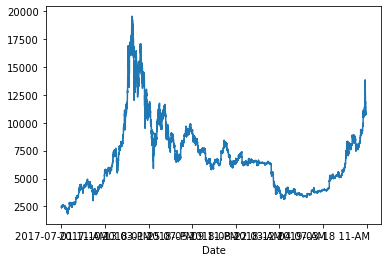

In [6]:
closedata.plot()

It can be observed that the Bitcoin closing price time series can be divided into several regions containg different trends with a stochastic component superimposed on them. Initially I'll consider the entire time series but this suggests that optimally forecasting should be done independently on the different regions.

<AxesSubplot:ylabel='Frequency'>

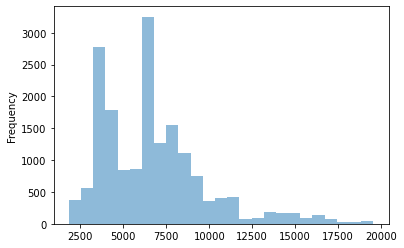

In [7]:
closedata.plot.hist(bins=25, alpha=0.5)

The time series is obviously nonGaussian, which can also be seen with a qqplot.

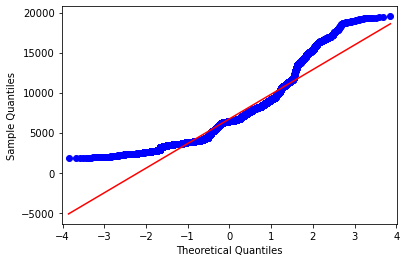

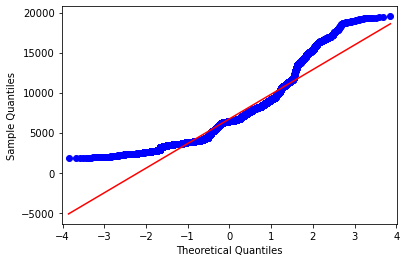

In [8]:
qqplot(closedata, line='s')

Generating the autocorrelation function of the time series we see it has a long correlation time. This is good for forecasting but given the shape of the time series (i.e. different regions with strong trends) this is not surprising.

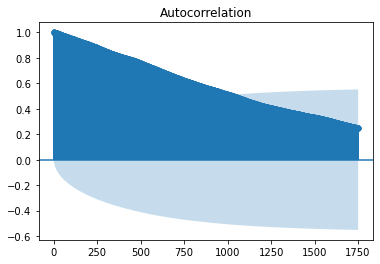

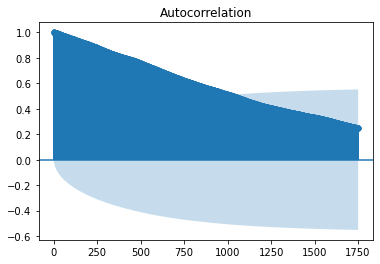

In [9]:
sm.graphics.tsa.plot_acf(closedata, lags=1750)

## Baseline Forecasts Using Simple Methods

The baseline forecasts are now applied to the raw Bitcoin price series

In [10]:
# one-step simple forecast
def simple_forecast(history, config):
    n, offset, avg_type = config
    # persist value, ignore other config
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
            # skip bad configs
        if n*offset > len(history):
                raise Exception('Config beyond end of data: %d %d' % (n,offset))
                # try and collect n values using offset
        for i in range(1, n+1):
                ix = i * offset
                values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean':
          return mean(values)
    # median of last n values
    return median(values)

In [11]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:] #I'm not using the entire time series for 'training'

In [12]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [13]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
    # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [14]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [15]:
# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

In [16]:

data = pd.read_csv('c:\\users\jamil\AnacondaProjects\Mariani_Prado\Kraken_BTCUSD_1h.csv', index_col= 0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %I-%p')
data=data.reindex(index=data.index[::-1])
data = (data['Close'])
data = data.values

# data split
n_test = len(data)*0.10
n_test = int(n_test)

# model configs
#max_length = len(data) - n_test
max_length = int(n_test/2) # only go so far back in the training data as half the length of the test data
print(len(data))
cfg_list = simple_configs(max_length) 
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
        print(cfg, error)

17439
 > Model[[1, 1, 'persist']] 80.078
 > Model[[2, 1, 'persist']] 114.290
 > Model[[2, 1, 'mean']] 90.190
 > Model[[2, 1, 'median']] 90.190
 > Model[[3, 1, 'persist']] 136.989
 > Model[[3, 1, 'mean']] 99.418
 > Model[[3, 1, 'median']] 107.177
 > Model[[4, 1, 'persist']] 156.210
 > Model[[4, 1, 'mean']] 108.066
 > Model[[4, 1, 'median']] 113.417
 > Model[[5, 1, 'persist']] 172.744
 > Model[[5, 1, 'mean']] 116.131
 > Model[[5, 1, 'median']] 124.759
 > Model[[6, 1, 'persist']] 186.316
 > Model[[6, 1, 'mean']] 123.321
 > Model[[6, 1, 'median']] 131.628
 > Model[[7, 1, 'persist']] 200.753
 > Model[[7, 1, 'mean']] 130.325
 > Model[[7, 1, 'median']] 141.849
 > Model[[8, 1, 'persist']] 215.397
 > Model[[8, 1, 'mean']] 137.298
 > Model[[8, 1, 'median']] 145.753
 > Model[[9, 1, 'persist']] 229.444
 > Model[[9, 1, 'mean']] 144.185
 > Model[[9, 1, 'median']] 153.442
 > Model[[10, 1, 'persist']] 240.857
 > Model[[10, 1, 'mean']] 150.607
 > Model[[10, 1, 'median']] 159.582
 > Model[[11, 1, 'persi

 > Model[[79, 1, 'median']] 443.295
 > Model[[80, 1, 'persist']] 672.064
 > Model[[80, 1, 'mean']] 403.908
 > Model[[80, 1, 'median']] 445.977
 > Model[[81, 1, 'persist']] 676.304
 > Model[[81, 1, 'mean']] 406.381
 > Model[[81, 1, 'median']] 448.894
 > Model[[82, 1, 'persist']] 680.680
 > Model[[82, 1, 'mean']] 408.845
 > Model[[82, 1, 'median']] 451.735
 > Model[[83, 1, 'persist']] 684.987
 > Model[[83, 1, 'mean']] 411.298
 > Model[[83, 1, 'median']] 454.806
 > Model[[84, 1, 'persist']] 688.974
 > Model[[84, 1, 'mean']] 413.735
 > Model[[84, 1, 'median']] 457.174
 > Model[[85, 1, 'persist']] 693.114
 > Model[[85, 1, 'mean']] 416.162
 > Model[[85, 1, 'median']] 459.784
 > Model[[86, 1, 'persist']] 697.114
 > Model[[86, 1, 'mean']] 418.574
 > Model[[86, 1, 'median']] 462.221
 > Model[[87, 1, 'persist']] 700.803
 > Model[[87, 1, 'mean']] 420.968
 > Model[[87, 1, 'median']] 464.945
 > Model[[88, 1, 'persist']] 704.577
 > Model[[88, 1, 'mean']] 423.345
 > Model[[88, 1, 'median']] 467.217
 

 > Model[[155, 1, 'median']] 623.594
 > Model[[156, 1, 'persist']] 1008.667
 > Model[[156, 1, 'mean']] 580.140
 > Model[[156, 1, 'median']] 625.759
 > Model[[157, 1, 'persist']] 1012.277
 > Model[[157, 1, 'mean']] 582.446
 > Model[[157, 1, 'median']] 628.041
 > Model[[158, 1, 'persist']] 1015.937
 > Model[[158, 1, 'mean']] 584.746
 > Model[[158, 1, 'median']] 630.305
 > Model[[159, 1, 'persist']] 1019.567
 > Model[[159, 1, 'mean']] 587.040
 > Model[[159, 1, 'median']] 632.687
 > Model[[160, 1, 'persist']] 1023.086
 > Model[[160, 1, 'mean']] 589.326
 > Model[[160, 1, 'median']] 635.017
 > Model[[161, 1, 'persist']] 1026.607
 > Model[[161, 1, 'mean']] 591.605
 > Model[[161, 1, 'median']] 637.452
 > Model[[162, 1, 'persist']] 1030.063
 > Model[[162, 1, 'mean']] 593.877
 > Model[[162, 1, 'median']] 639.083
 > Model[[163, 1, 'persist']] 1033.459
 > Model[[163, 1, 'mean']] 596.141
 > Model[[163, 1, 'median']] 640.870
 > Model[[164, 1, 'persist']] 1036.794
 > Model[[164, 1, 'mean']] 598.397
 

 > Model[[229, 1, 'median']] 800.289
 > Model[[230, 1, 'persist']] 1230.808
 > Model[[230, 1, 'mean']] 732.439
 > Model[[230, 1, 'median']] 802.797
 > Model[[231, 1, 'persist']] 1233.794
 > Model[[231, 1, 'mean']] 734.298
 > Model[[231, 1, 'median']] 805.346
 > Model[[232, 1, 'persist']] 1236.882
 > Model[[232, 1, 'mean']] 736.153
 > Model[[232, 1, 'median']] 807.822
 > Model[[233, 1, 'persist']] 1240.041
 > Model[[233, 1, 'mean']] 738.006
 > Model[[233, 1, 'median']] 810.336
 > Model[[234, 1, 'persist']] 1242.907
 > Model[[234, 1, 'mean']] 739.854
 > Model[[234, 1, 'median']] 812.666
 > Model[[235, 1, 'persist']] 1245.655
 > Model[[235, 1, 'mean']] 741.698
 > Model[[235, 1, 'median']] 815.034
 > Model[[236, 1, 'persist']] 1248.628
 > Model[[236, 1, 'mean']] 743.538
 > Model[[236, 1, 'median']] 817.508
 > Model[[237, 1, 'persist']] 1251.359
 > Model[[237, 1, 'mean']] 745.374
 > Model[[237, 1, 'median']] 820.024
 > Model[[238, 1, 'persist']] 1254.203
 > Model[[238, 1, 'mean']] 747.204
 

 > Model[[304, 1, 'median']] 962.287
 > Model[[305, 1, 'persist']] 1441.449
 > Model[[305, 1, 'mean']] 863.133
 > Model[[305, 1, 'median']] 964.052
 > Model[[306, 1, 'persist']] 1443.676
 > Model[[306, 1, 'mean']] 864.747
 > Model[[306, 1, 'median']] 965.573
 > Model[[307, 1, 'persist']] 1445.899
 > Model[[307, 1, 'mean']] 866.356
 > Model[[307, 1, 'median']] 967.116
 > Model[[308, 1, 'persist']] 1448.021
 > Model[[308, 1, 'mean']] 867.960
 > Model[[308, 1, 'median']] 968.761
 > Model[[309, 1, 'persist']] 1450.203
 > Model[[309, 1, 'mean']] 869.561
 > Model[[309, 1, 'median']] 970.428
 > Model[[310, 1, 'persist']] 1452.232
 > Model[[310, 1, 'mean']] 871.156
 > Model[[310, 1, 'median']] 972.021
 > Model[[311, 1, 'persist']] 1454.336
 > Model[[311, 1, 'mean']] 872.748
 > Model[[311, 1, 'median']] 973.635
 > Model[[312, 1, 'persist']] 1456.381
 > Model[[312, 1, 'mean']] 874.334
 > Model[[312, 1, 'median']] 975.215
 > Model[[313, 1, 'persist']] 1458.355
 > Model[[313, 1, 'mean']] 875.916
 

 > Model[[379, 1, 'persist']] 1586.356
 > Model[[379, 1, 'mean']] 972.445
 > Model[[379, 1, 'median']] 1061.471
 > Model[[380, 1, 'persist']] 1588.040
 > Model[[380, 1, 'mean']] 973.808
 > Model[[380, 1, 'median']] 1062.858
 > Model[[381, 1, 'persist']] 1589.722
 > Model[[381, 1, 'mean']] 975.167
 > Model[[381, 1, 'median']] 1064.261
 > Model[[382, 1, 'persist']] 1591.467
 > Model[[382, 1, 'mean']] 976.523
 > Model[[382, 1, 'median']] 1065.663
 > Model[[383, 1, 'persist']] 1593.177
 > Model[[383, 1, 'mean']] 977.876
 > Model[[383, 1, 'median']] 1067.079
 > Model[[384, 1, 'persist']] 1594.878
 > Model[[384, 1, 'mean']] 979.226
 > Model[[384, 1, 'median']] 1067.860
 > Model[[385, 1, 'persist']] 1596.319
 > Model[[385, 1, 'mean']] 980.572
 > Model[[385, 1, 'median']] 1068.673
 > Model[[386, 1, 'persist']] 1597.778
 > Model[[386, 1, 'mean']] 981.914
 > Model[[386, 1, 'median']] 1069.751
 > Model[[387, 1, 'persist']] 1599.407
 > Model[[387, 1, 'mean']] 983.253
 > Model[[387, 1, 'median']] 1

 > Model[[452, 1, 'median']] 1142.886
 > Model[[453, 1, 'persist']] 1679.764
 > Model[[453, 1, 'mean']] 1063.339
 > Model[[453, 1, 'median']] 1144.109
 > Model[[454, 1, 'persist']] 1681.360
 > Model[[454, 1, 'mean']] 1064.434
 > Model[[454, 1, 'median']] 1145.160
 > Model[[455, 1, 'persist']] 1682.922
 > Model[[455, 1, 'mean']] 1065.528
 > Model[[455, 1, 'median']] 1146.220
 > Model[[456, 1, 'persist']] 1684.340
 > Model[[456, 1, 'mean']] 1066.619
 > Model[[456, 1, 'median']] 1147.429
 > Model[[457, 1, 'persist']] 1685.847
 > Model[[457, 1, 'mean']] 1067.708
 > Model[[457, 1, 'median']] 1148.649
 > Model[[458, 1, 'persist']] 1687.430
 > Model[[458, 1, 'mean']] 1068.795
 > Model[[458, 1, 'median']] 1150.012
 > Model[[459, 1, 'persist']] 1689.058
 > Model[[459, 1, 'mean']] 1069.881
 > Model[[459, 1, 'median']] 1151.388
 > Model[[460, 1, 'persist']] 1690.722
 > Model[[460, 1, 'mean']] 1070.966
 > Model[[460, 1, 'median']] 1152.654
 > Model[[461, 1, 'persist']] 1692.279
 > Model[[461, 1, '

 > Model[[525, 1, 'median']] 1217.017
 > Model[[526, 1, 'persist']] 1789.655
 > Model[[526, 1, 'mean']] 1139.181
 > Model[[526, 1, 'median']] 1217.291
 > Model[[527, 1, 'persist']] 1790.830
 > Model[[527, 1, 'mean']] 1140.159
 > Model[[527, 1, 'median']] 1217.572
 > Model[[528, 1, 'persist']] 1791.891
 > Model[[528, 1, 'mean']] 1141.135
 > Model[[528, 1, 'median']] 1218.732
 > Model[[529, 1, 'persist']] 1792.958
 > Model[[529, 1, 'mean']] 1142.109
 > Model[[529, 1, 'median']] 1219.897
 > Model[[530, 1, 'persist']] 1793.998
 > Model[[530, 1, 'mean']] 1143.080
 > Model[[530, 1, 'median']] 1221.185
 > Model[[531, 1, 'persist']] 1794.910
 > Model[[531, 1, 'mean']] 1144.048
 > Model[[531, 1, 'median']] 1222.481
 > Model[[532, 1, 'persist']] 1795.940
 > Model[[532, 1, 'mean']] 1145.014
 > Model[[532, 1, 'median']] 1223.779
 > Model[[533, 1, 'persist']] 1796.849
 > Model[[533, 1, 'mean']] 1145.977
 > Model[[533, 1, 'median']] 1225.085
 > Model[[534, 1, 'persist']] 1797.682
 > Model[[534, 1, '

 > Model[[599, 1, 'persist']] 1872.876
 > Model[[599, 1, 'mean']] 1204.248
 > Model[[599, 1, 'median']] 1286.559
 > Model[[600, 1, 'persist']] 1874.824
 > Model[[600, 1, 'mean']] 1205.095
 > Model[[600, 1, 'median']] 1287.423
 > Model[[601, 1, 'persist']] 1876.748
 > Model[[601, 1, 'mean']] 1205.941
 > Model[[601, 1, 'median']] 1288.288
 > Model[[602, 1, 'persist']] 1878.627
 > Model[[602, 1, 'mean']] 1206.788
 > Model[[602, 1, 'median']] 1289.282
 > Model[[603, 1, 'persist']] 1880.620
 > Model[[603, 1, 'mean']] 1207.635
 > Model[[603, 1, 'median']] 1290.284
 > Model[[604, 1, 'persist']] 1882.620
 > Model[[604, 1, 'mean']] 1208.482
 > Model[[604, 1, 'median']] 1291.304
 > Model[[605, 1, 'persist']] 1884.582
 > Model[[605, 1, 'mean']] 1209.329
 > Model[[605, 1, 'median']] 1292.334
 > Model[[606, 1, 'persist']] 1886.458
 > Model[[606, 1, 'mean']] 1210.177
 > Model[[606, 1, 'median']] 1293.279
 > Model[[607, 1, 'persist']] 1888.373
 > Model[[607, 1, 'mean']] 1211.024
 > Model[[607, 1, 'me

 > Model[[671, 1, 'median']] 1357.094
 > Model[[672, 1, 'persist']] 2005.459
 > Model[[672, 1, 'mean']] 1265.990
 > Model[[672, 1, 'median']] 1357.822
 > Model[[673, 1, 'persist']] 2007.446
 > Model[[673, 1, 'mean']] 1266.831
 > Model[[673, 1, 'median']] 1358.564
 > Model[[674, 1, 'persist']] 2009.300
 > Model[[674, 1, 'mean']] 1267.673
 > Model[[674, 1, 'median']] 1359.546
 > Model[[675, 1, 'persist']] 2011.117
 > Model[[675, 1, 'mean']] 1268.514
 > Model[[675, 1, 'median']] 1360.534
 > Model[[676, 1, 'persist']] 2012.953
 > Model[[676, 1, 'mean']] 1269.356
 > Model[[676, 1, 'median']] 1361.552
 > Model[[677, 1, 'persist']] 2014.760
 > Model[[677, 1, 'mean']] 1270.198
 > Model[[677, 1, 'median']] 1362.577
 > Model[[678, 1, 'persist']] 2016.734
 > Model[[678, 1, 'mean']] 1271.040
 > Model[[678, 1, 'median']] 1363.150
 > Model[[679, 1, 'persist']] 2018.835
 > Model[[679, 1, 'mean']] 1271.882
 > Model[[679, 1, 'median']] 1363.766
 > Model[[680, 1, 'persist']] 2020.954
 > Model[[680, 1, '

 > Model[[745, 1, 'mean']] 1328.506
 > Model[[745, 1, 'median']] 1435.535
 > Model[[746, 1, 'persist']] 2160.524
 > Model[[746, 1, 'mean']] 1329.384
 > Model[[746, 1, 'median']] 1436.740
 > Model[[747, 1, 'persist']] 2162.614
 > Model[[747, 1, 'mean']] 1330.263
 > Model[[747, 1, 'median']] 1437.980
 > Model[[748, 1, 'persist']] 2164.745
 > Model[[748, 1, 'mean']] 1331.143
 > Model[[748, 1, 'median']] 1439.183
 > Model[[749, 1, 'persist']] 2167.035
 > Model[[749, 1, 'mean']] 1332.023
 > Model[[749, 1, 'median']] 1440.423
 > Model[[750, 1, 'persist']] 2169.352
 > Model[[750, 1, 'mean']] 1332.904
 > Model[[750, 1, 'median']] 1441.667
 > Model[[751, 1, 'persist']] 2171.672
 > Model[[751, 1, 'mean']] 1333.786
 > Model[[751, 1, 'median']] 1442.944
 > Model[[752, 1, 'persist']] 2173.988
 > Model[[752, 1, 'mean']] 1334.668
 > Model[[752, 1, 'median']] 1444.181
 > Model[[753, 1, 'persist']] 2176.198
 > Model[[753, 1, 'mean']] 1335.552
 > Model[[753, 1, 'median']] 1445.453
 > Model[[754, 1, 'per

 > Model[[818, 1, 'median']] 1531.675
 > Model[[819, 1, 'persist']] 2301.495
 > Model[[819, 1, 'mean']] 1394.104
 > Model[[819, 1, 'median']] 1533.024
 > Model[[820, 1, 'persist']] 2303.555
 > Model[[820, 1, 'mean']] 1394.993
 > Model[[820, 1, 'median']] 1534.350
 > Model[[821, 1, 'persist']] 2305.621
 > Model[[821, 1, 'mean']] 1395.883
 > Model[[821, 1, 'median']] 1535.704
 > Model[[822, 1, 'persist']] 2307.698
 > Model[[822, 1, 'mean']] 1396.773
 > Model[[822, 1, 'median']] 1537.022
 > Model[[823, 1, 'persist']] 2309.702
 > Model[[823, 1, 'mean']] 1397.664
 > Model[[823, 1, 'median']] 1538.369
 > Model[[824, 1, 'persist']] 2311.713
 > Model[[824, 1, 'mean']] 1398.555
 > Model[[824, 1, 'median']] 1539.693
 > Model[[825, 1, 'persist']] 2313.706
 > Model[[825, 1, 'mean']] 1399.446
 > Model[[825, 1, 'median']] 1541.046
 > Model[[826, 1, 'persist']] 2315.755
 > Model[[826, 1, 'mean']] 1400.337
 > Model[[826, 1, 'median']] 1542.361
 > Model[[827, 1, 'persist']] 2317.818
 > Model[[827, 1, '

The best performing forecasting method was the persistence method applied one step backwards in the price time series. The next best were mean and the median of the previous two values.

## Discussion

Given the disjointed nature of the bitcoin time series these results aren't too surprising. There is no prediocity in the time series and it can clearly been seen to consist of regions or domains with different trends. Data from one domain would not be expected to be useful for forecasting in another domain. Nevertheless, it is perhaps disappointing that the best forecasts were obtained using data immediately prior to the predicted data, suggesting the time series may not contain much predictability. After having established baseline forecasting performanes, in the next notebook I apply a Neural Network to forecasting Bitcoin prices.